# Classification of Kannada MNIST
## Preamble of kannada digits


In [96]:
# Author: Vikas Chidananda

# Dataset credits: Vinay Uday Prabhu
# Prabhu, V. (2019, August 03). Kannada-MNIST: A new handwritten DIGITS dataset 
#     for the Kannada language. Retrieved April 19, 2021, 
#     from https://arxiv.org/abs/1908.01242v1

In [44]:
import numpy as np
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt 

from sklearn import svm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tqdm import tqdm

In [3]:
path_test_data = 'Kannada-MNIST_data/test.csv'
path_train_data = 'Kannada-MNIST_data/train.csv'
df_test = pd.read_csv(path_test_data)
df_train = pd.read_csv(path_train_data)

In [18]:
df_train.head()
df_test.head()

,id,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
labels, data = df_train['label'].to_numpy(), df_train.iloc[:, 1:].to_numpy()
train_data, test_data, train_labels, test_labels = train_test_split(
                                                                data, labels, test_size = 0.05, random_state = 1)

In [38]:
num_components, num_data = len(np.unique(train_labels)), train_data.shape[0]
# normalize the data
train_data = train_data/255.0
test_data = test_data/255.0

print(train_data.shape, train_labels.shape)
print(test_data.shape, test_labels.shape)

(57000, 784) (57000,)
(3000, 784) (3000,)


In [17]:
# store data as images
test_labels

array([   0,    1,    2, ..., 4997, 4998, 4999], dtype=int64)

## Visualize some of the data

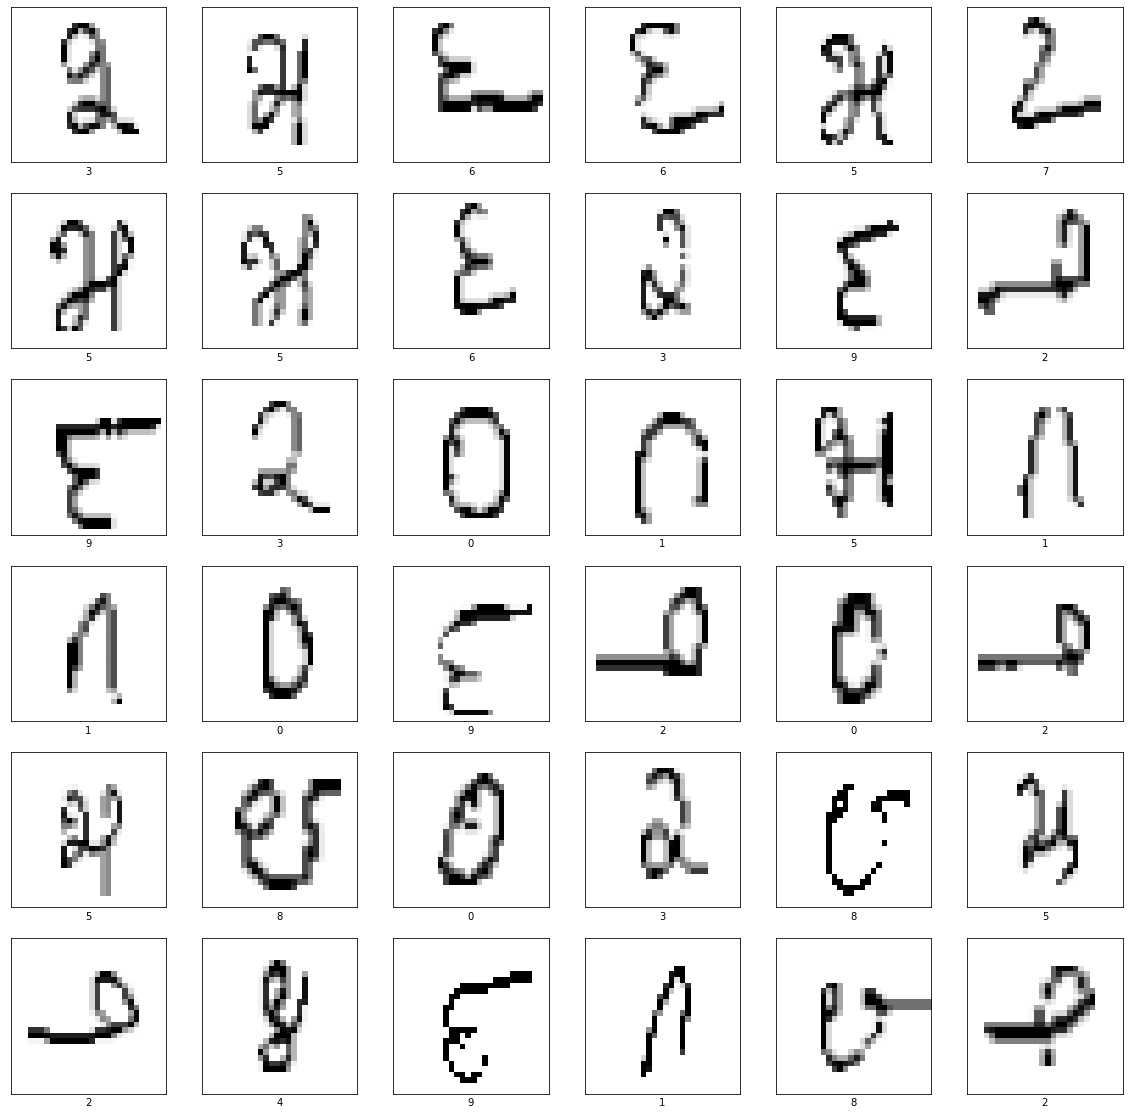

In [26]:
plt.figure(figsize=(20,20))
random_inds = np.random.choice(48000,36)

for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    digit = train_data[image_ind]
    plt.imshow(np.resize(digit, (28, 28)), cmap = plt.cm.binary)
#     print(train_labels[image_ind])
    plt.xlabel(train_labels[image_ind])

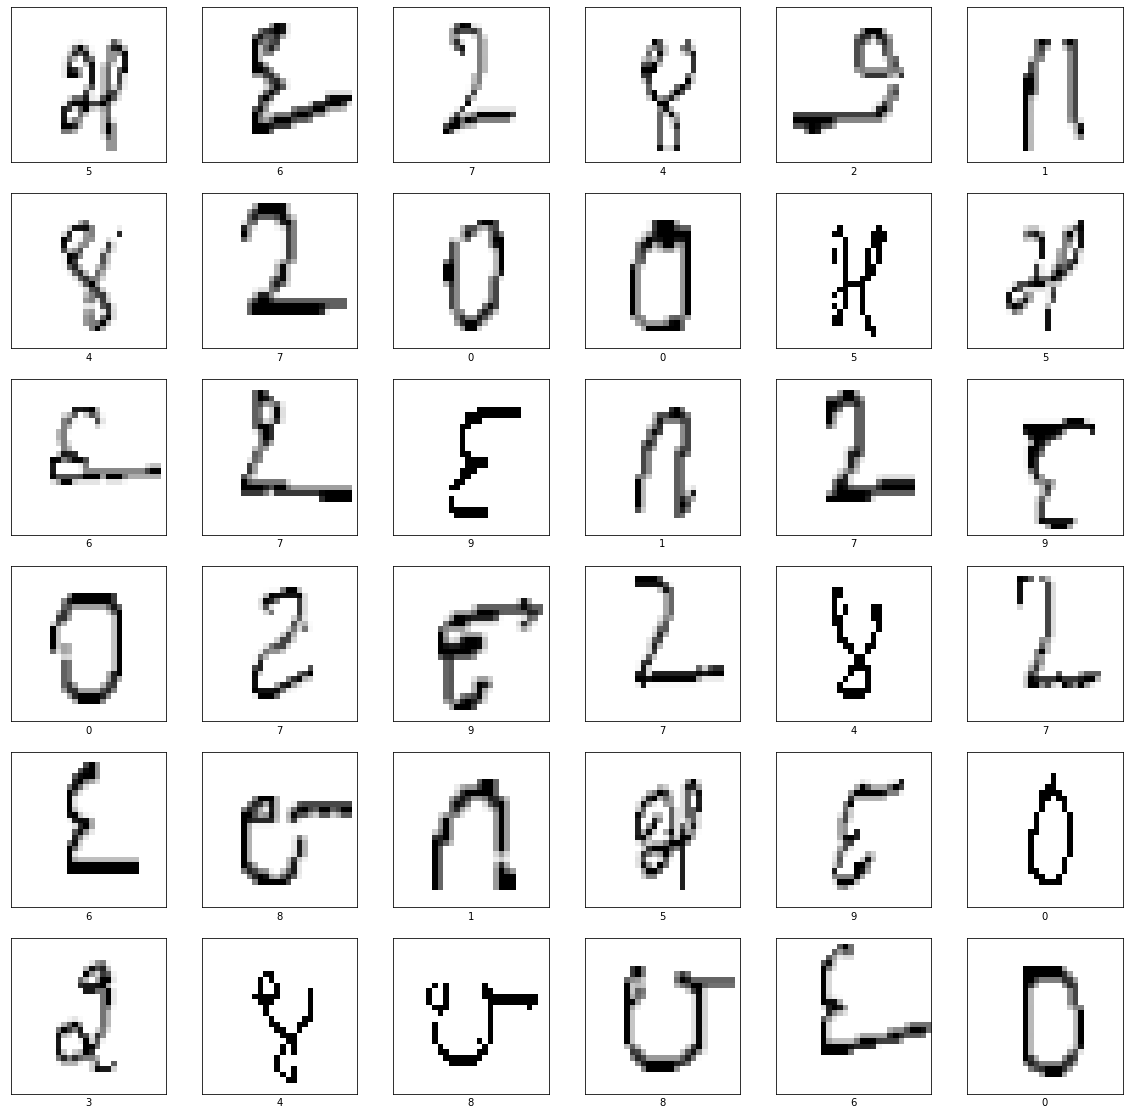

In [27]:
plt.figure(figsize=(20,20))
random_inds = np.random.choice(5000,36)

for i in range(36):
    plt.subplot(6,6,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = random_inds[i]
    digit = test_data[image_ind]
    plt.imshow(np.resize(digit, (28, 28)), cmap = plt.cm.binary)
#     print(train_labels[image_ind])
    plt.xlabel(test_labels[image_ind])

In [ ]:
# To do improve image quality - discontinuity


### SVM

In [28]:
# Since most of the data is empty (0's) let's use LDA to reduce the data space

clf_lda = LDA()
%timeit clf_lda.fit(train_data, train_labels)

12 s ± 420 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
print(f'Score on trained data: {clf_lda.score(train_data, train_labels)}')
print(f'Score on test data: {clf_lda.score(test_data, test_labels)}')

Score on trained data: 0.9358958333333334
Score on test data: 0.92775


In [30]:
test_data_reduced = clf_lda.transform(test_data)
train_data_reduced = clf_lda.transform(train_data)

clf_reduced = LDA()
clf_reduced.fit(train_data_reduced, train_labels)

print(f'Score on trained data: {clf_reduced.score(train_data_reduced, train_labels)}')
print(f'Score on test data: {clf_reduced.score(test_data_reduced, test_labels)}')

Score on trained data: 0.9358958333333334
Score on test data: 0.92775


### Deeplearning (NN) with different architectures

In [56]:
def build_model():                                                 #layers as arguments
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(512, activation = 'relu'),
        tf.keras.layers.Dense(128, activation = 'relu'),
        
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(10, activation = 'sigmoid')
    ])
    return nn_model

model = build_model()

In [57]:
model.compile(
    optimizer = tf.keras.optimizers.SGD(learning_rate = 1e-1),
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy'])


In [58]:
batch_size = 32
epochs = 5

model.fit(train_data, train_labels, batch_size = batch_size, epochs = epochs)

Epoch 1/5
1782/1782 [==============================] - 12s 6ms/step - loss: 0.1864 - accuracy: 0.9472
Epoch 2/5
1782/1782 [==============================] - 12s 6ms/step - loss: 0.0773 - accuracy: 0.9772
Epoch 3/5
1782/1782 [==============================] - 11s 6ms/step - loss: 0.0522 - accuracy: 0.9848
Epoch 4/5
1782/1782 [==============================] - 11s 6ms/step - loss: 0.0388 - accuracy: 0.9888
Epoch 5/5
1782/1782 [==============================] - 11s 6ms/step - loss: 0.0293 - accuracy: 0.9914


In [59]:
test_loss, test_acc = model.evaluate(test_data, test_labels, verbose=2)

print('Test accuracy:', test_acc, test_loss)

94/94 - 0s - loss: 0.0537 - accuracy: 0.9817
Test accuracy: 0.9816666841506958 0.05370539426803589


In [60]:
predictions = model.predict(test_data)
predictions = np.argmax(predictions, axis = -1)
predictions

array([1, 5, 6, ..., 2, 0, 2], dtype=int64)

In [61]:
np.unique(labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int64)

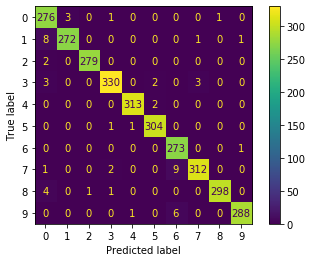

In [62]:
cm = confusion_matrix(test_labels, predictions, labels=np.unique(labels))
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=np.unique(labels))
disp.plot()

In [82]:
#print misclassified digits
idxs = np.where(predictions != test_labels)
idxs = np.array(idxs, dtype = int)
idxs[0]

array([   7,   47,   73,  134,  140,  247,  251,  401,  457,  536,  693,
        714,  715,  740,  778,  790,  844,  883,  915, 1048, 1070, 1157,
       1195, 1264, 1275, 1336, 1351, 1416, 1473, 1493, 1534, 1640, 1670,
       1751, 1783, 1879, 1886, 2005, 2035, 2045, 2064, 2112, 2134, 2189,
       2258, 2287, 2336, 2472, 2587, 2609, 2730, 2784, 2880, 2886, 2964])

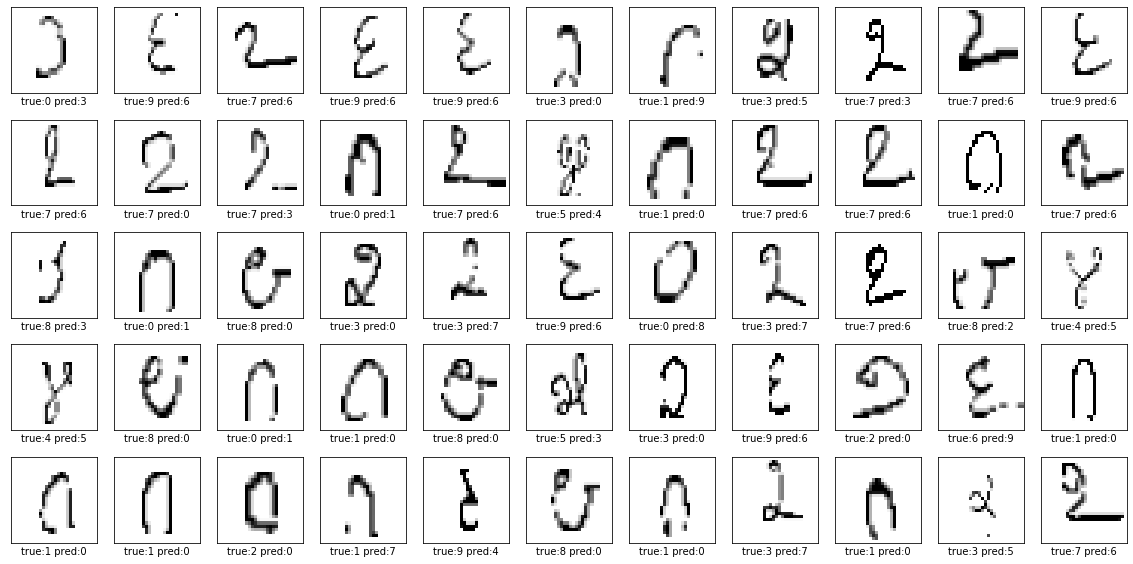

In [93]:
plt.figure(figsize=(20,10))
for i in range(len(idxs[0])):
    plt.subplot(5,11, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    image_ind = idxs[0][i]
    digit = test_data[image_ind]
    plt.imshow(np.resize(digit, (28, 28)), cmap = plt.cm.binary)
#     print(train_labels[image_ind])
    plt.xlabel('true:'+str(test_labels[image_ind])+' pred:'+str(predictions[image_ind] ))
    

In [72]:
#histograms of wrongly predicted labels
counts = 

False

#### CNN with different architecture

In [63]:
def CNN_model():
    cnn_model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, 3, activation = 'relu'),
        tf.keras.layers.MaxPool2D(),
        tf.layers.layers.Conv2D
    ])